In [3]:
%matplotlib inline

import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from extra_data import open_run
from scipy.stats import theilslopes
from skimage.draw import line_aa
from skimage.exposure import equalize_hist
from skimage.measure import LineModelND, ransac
from tqdm.auto import tqdm
import xarray as xr

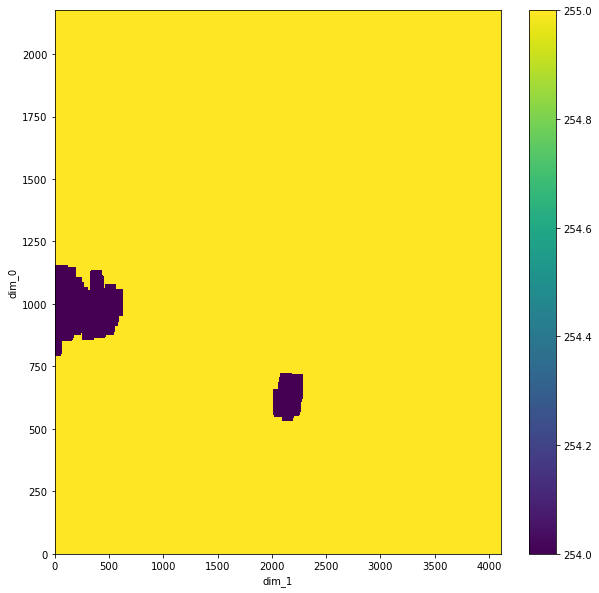

In [5]:
data = np.load('cam2_mask.npy')
xr.DataArray(~data).plot(figsize=(10,10))

# Define functions

In [2]:
def normalize(data):
    return cv2.normalize(data, None, 255, 0, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def get_threshold(data, mask, kernel=(81, 81)):
    """Find foreground threshold
    """
    data = cv2.bitwise_and(data, data, mask=~mask)
    smooth = cv2.blur(data, kernel, 0)
    blur = cv2.divide(data, smooth, scale=255)
    blur = cv2.bitwise_not(blur, mask=~mask)
    blur = cv2.GaussianBlur(blur, (5, 5), 0)
    _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return blur, threshold.astype(bool)

def median_per_row(_x):
    return np.asarray([np.median(l.nonzero()[0]) for l in _x])

def argmax_per_row(_x, kernel=(101, 101)):
    _x = cv2.GaussianBlur(_x, kernel, 0)
    return np.argmax(_x, axis=1)

def fit_theil_sen(x, y=None):
    y = y or np.arange(x.shape[0])
    res = theilslopes(x, y, 0.9, method='separate')
    return res[0] * y + res[1], y

def fit_ransac(x, y=None):
    y = y or np.arange(x.shape[0])
    data = np.column_stack([y, x])
    model, inliers = ransac(data, LineModelND, min_samples=2, residual_threshold=5, max_trials=1000)
    return model.predict_y(y), y

def dead_pixel_mask(kd, proposal, runnb, kernel=(81, 81), output='/tmp/'):
    """Get a dead pixel map for the given KeyData
    
    Dead pixel are estimated with invariant pixel over all frames in the data
    """
    output = f'{output}/mask-{proposal}-{runnb}-{kd.source.partition(":")[0].replace("/", "_")}-{kd.key.replace(".", "_")}.npy'
    if os.path.isfile(output):
        return np.load(output)

    var = np.var(kd.ndarray(), axis=0)
    mask = np.zeros_like(var, dtype=np.uint8)
    mask[var == 0] = 255
    np.save(output, mask)
    return mask

def fit_jet(frame, mask, debug=False):
    """Fit a line to the sample jet in this frame.
    """
    data = normalize(frame)
    blur, threshold = get_threshold(data, mask)
    foreground = data * threshold
#     result = cv2.GaussianBlur(foreground, kernel, 0)
    
#     y = np.arange(result.shape[0])
#     x = np.argmax(result, axis=1)
#     res = theilslopes(x, y, 0.90, method='separate')

    x = median_per_row(foreground)
    # res, y = fit_ransac(x)
    res, y = fit_ransac(x)
    
    if debug:
        return {
            'data': data,
            'mask': mask,
            'blur': blur,
            'threshold': threshold,
            'foreground': foreground,
            # 'foreground_gaussian_blur': result,
            'x': x,
            'y': y,
            'fit': res,
        }
    return res

In [3]:
def debug_plot(results):
    
    y = results['y']
    x = results['x']
    res = results['fit']

    fig, _ = plt.subplots(2, 3, figsize=(21, 14))
    ax = fig.axes
    
    ax[0].imshow(results['mask'])
    ax[0].set_title('Dead pixel mask')

    ax[1].imshow(results['threshold'])
    ax[1].set_title('Threshold')

    ax[2].imshow(results['foreground'])
    ax[2].set_title('Foreground')

    ax[3].imshow(equalize_hist(results['data']))
    ax[3].plot(res, y, 'r-')
    ax[3].set_title('Raw frame (equalized histogram) with fitted line')

    ax[4].imshow(results['data'])
    ax[4].set_title('Raw frame')

    ax[5].plot(x, y, 'b.')
    ax[5].plot(res, y,'r-')
    ax[5].invert_yaxis()
    ax[5].set_title('Fit')


def make_film(kd, mask, output, fps=10, eq_hist=False):
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec (e.g., XVID, MJPG, etc.)
    # Get the shape of the first frame to determine video dimensions
    video_writer = cv2.VideoWriter(output, fourcc, fps, kd.entry_shape[::-1])
    
    data = kd.ndarray()
    for frame in tqdm(data):
        res = fit_jet(frame, mask)

        maxr = frame.shape[0] - 1
        rr, cc, val = line_aa(
            0, int(res[0]),
            maxr, int(res[-1])
        )
        
        if eq_hist:
            frame = equalize_hist(frame)
        frame = normalize(frame)
        # Convert the 2D frame to 3D by repeating the channels
        frame_3d = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

        frame_3d[rr, cc, 2] = val * 255
        frame_3d[rr, cc, :2] = 0

        # Write the frame to the video
        video_writer.write(frame_3d)
        
    # Release the VideoWriter and close the output file
    video_writer.release()

# Input data

In [4]:
proposal = 900338
runnb = 310

sel = open_run(proposal, runnb).select([
    ('HED_EXP_PPT/CAM/CAM_1:daqOutput', 'data.image.pixels'),
    ('HED_IA1_LT/CAM/FSI:daqOutput', 'data.image.pixels')],
    # require_all=True,
)

cam_1 = sel['HED_EXP_PPT/CAM/CAM_1:daqOutput', 'data.image.pixels'].drop_empty_trains()
cam_2 = sel['HED_IA1_LT/CAM/FSI:daqOutput', 'data.image.pixels'].drop_empty_trains()

# Test

CPU times: user 237 ms, sys: 248 ms, total: 486 ms
Wall time: 457 ms


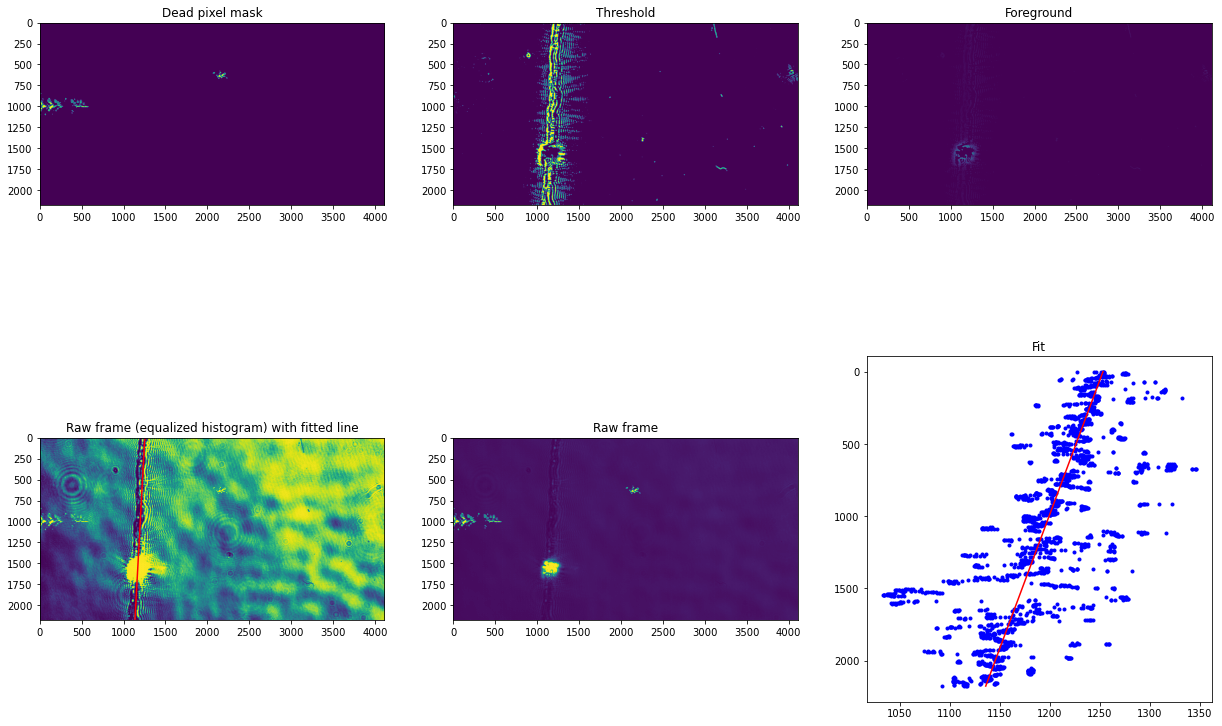

In [5]:
cam = cam_2
frame = 111

data = cam[frame].ndarray().squeeze()
mask = dead_pixel_mask(cam, proposal, runnb)

%time results = fit_jet(data, mask, debug=True)
debug_plot(results)

# DEV

CPU times: user 100 ms, sys: 65 µs, total: 100 ms
Wall time: 100 ms
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms
CPU times: user 66.2 ms, sys: 0 ns, total: 66.2 ms
Wall time: 66.2 ms
CPU times: user 104 ms, sys: 11 µs, total: 104 ms
Wall time: 104 ms


(800.0, 2400.0)

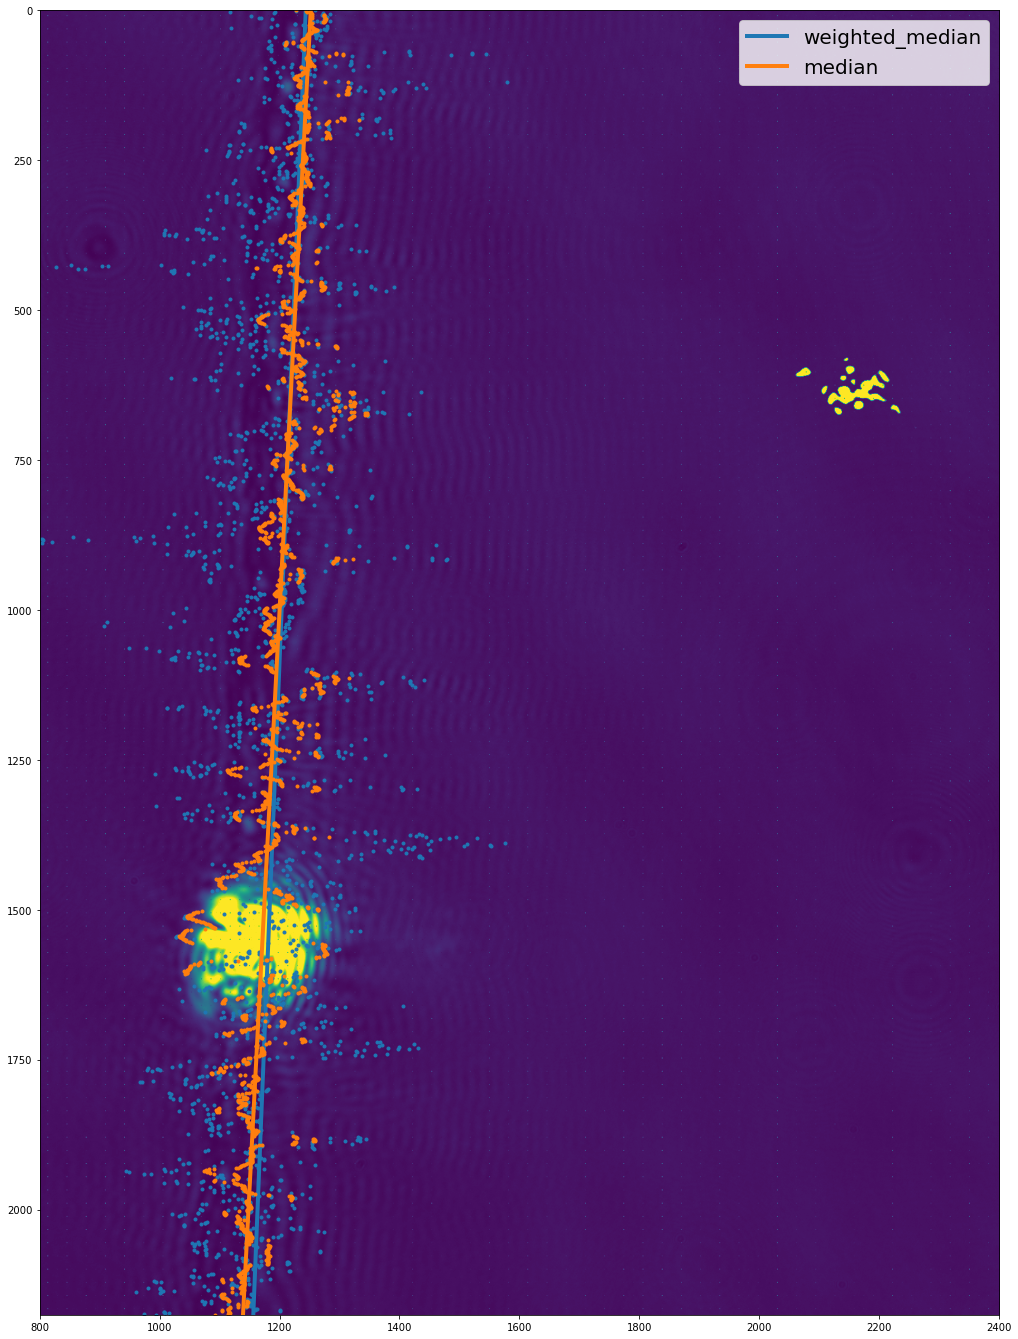

In [7]:
def median(_x):
    # return np.asarray([np.median(l.nonzero()[0]) for l in _x])
    return np.apply_along_axis(lambda v: np.median(np.nonzero(v)[0]), 1, _x)

def weighted_median(_x):
    ret = []
    for line in _x:
        nz = line.nonzero()[0]
        ret.append(np.median(nz * line[nz]) / np.median(line[nz]))
    return np.asarray(ret)

def weighted_median_2(_x):
    ret = []
    for line in _x:
        nz = line.nonzero()[0]
        ret.append((nz * line[nz]).sum() / line[nz].sum())
    return np.asarray(ret)


def _weighted_quantiles_interpolate(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    q = np.searchsorted(c, quantiles * c[-1])
    return np.where(c[q]/c[-1] == quantiles, 0.5 * (values[i[q]] + values[i[q+1]]), values[i[q]])

def weighted_median_3(_x):
    res = []
    for line in _x:
        values = line.nonzero()[0]
        weights = line[values]
        res.append(_weighted_quantiles_interpolate(values, weights))
    return np.asarray(res)

def cmax(_x):
    res = []
    for line in _x:
        apmax = np.argwhere(line == line.max())
        center = (apmax * line[apmax]).sum() / line[apmax].sum()
        # center = np.median(apmax)
        res.append(center)
    return np.asarray(res)

def com(arr):
    row_indices = np.arange(arr.shape[1])
    row_totals = np.sum(arr, axis=1)
    center_of_mass = np.sum(arr * row_indices, axis=1) / row_totals
    center_of_mass[row_totals == 0] = np.nan
    return center_of_mass


def argmax(_x):
    _x = cv2.GaussianBlur(_x, (101, 101), 0)
    return np.argmax(_x, axis=1)


def smooth(_x):
    from scipy.signal import savgol_filter
    filt = savgol_filter(_x, 251, 2)
    return cmax(filt)



def _fit(x):
    y = np.arange(len(x))
    res = theilslopes(x, y, 0.9)
    return res[0] * y + res[1], y

def _fit_r(x):
    from skimage.measure import LineModelND, ransac
    y = np.arange(len(x))
    data = np.column_stack([y, x])
    model, inliers = ransac(data, LineModelND, min_samples=2, residual_threshold=5, max_trials=1000)
    return model.predict_y(y), y
        

    
cam = cam_2
frame = 111
data = cam[frame].ndarray().squeeze()
mask = dead_pixel_mask(cam, proposal, runnb)
results = fit_jet(data, mask, debug=True)

roi = np.s_[:, :]
# fg = results['blur'][roi] * results['threshold'][roi]
fg = results['foreground']

funcs = [
    # com,
    # cmax,
    # weighted_median_3,
    # weighted_median_2,
    weighted_median,
    median,
    # argmax,
    # smooth,
]

fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(results['data'][roi])
for func, color in zip(funcs, plt.cm.colors.TABLEAU_COLORS):
    %time pts = func(fg)
    ax.plot(func(fg), np.arange(fg.shape[0]),'.', color=color)

    # for _f in [_fit, _fit_r]:
    %time est = _fit_r(pts)
    ax.plot(*est, linewidth=4, label=f'{func.__name__}')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_xlim(800, 2400)
# ax.set_ylim(150, 400)

In [15]:
cam = cam_1
mask = dead_pixel_mask(cam, proposal, runnb)
make_film(cam, mask, f'/home/tmichela/outputs/p900338-p{proposal}-r{runnb}-{cam.source.partition(":")[0].replace("/", "_")}-with-fit.mp4')

  0%|          | 0/786 [00:00<?, ?it/s]

In [5]:
import numpy as np
mat = np.array([[1, 1], [1, 2]])
xy = np.array([[1, 0]])
np.linalg.solve(mat, xy.T).T

array([[ 2., -1.]])

In [2]:
np.rot90(1)

ValueError: Axes=(0, 1) out of range for array of ndim=0.